# Tensorflow Object Detection API for Trafic Sign Detection

Dataset:
https://hci.iwr.uni-heidelberg.de/node/6132

Sample Example:
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_pets.md

In [26]:
import tensorflow as tf
import yaml # http://pyyaml.org/wiki/PyYAMLDocumentation (pip install pyyaml)
import io
import os
import random
import matplotlib.pyplot as plt

Playing with the dataset

In [62]:
train_folder = "/media/yousof/Volume/SDC/DataSets/BoschTrafficLight/dataset_train_rgb.zip.001_FILES"
test_folder = "/media/yousof/Volume/SDC/DataSets/BoschTrafficLight/dataset_test_rgb.zip.001_FILES"

train_yaml_p = os.path.join(train_folder,'train.yaml')
test_yaml_p = os.path.join(test_folder,'test.yaml')

In [175]:
with open(train_yaml_p,'r') as tryml:
    tr = yaml.load(tryml)

with open(test_yaml_p,'r') as teyml:
    te = yaml.load(teyml)

In [56]:
idx = random.randint(0,len(tr))

2261
{'boxes': [{'label': 'Yellow', 'occluded': False, 'x_max': 665.8574686147, 'x_min': 660.3744189028, 'y_max': 310.4410027537, 'y_min': 302.3048644715}, {'label': 'Yellow', 'occluded': False, 'x_max': 734.4821160871, 'x_min': 730.5503283883, 'y_max': 322.9447259802, 'y_min': 316.3917464822}, {'label': 'off', 'occluded': False, 'x_max': 610.214962454, 'x_min': 605.2685001403, 'y_max': 305.8485031216, 'y_min': 296.0967101555}, {'label': 'off', 'occluded': False, 'x_max': 640.3513687771, 'x_min': 637.1362888237, 'y_max': 307.0795179886, 'y_min': 298.272994638}], 'path': './rgb/train/2015-10-05-14-40-46_bag/448216.png'}


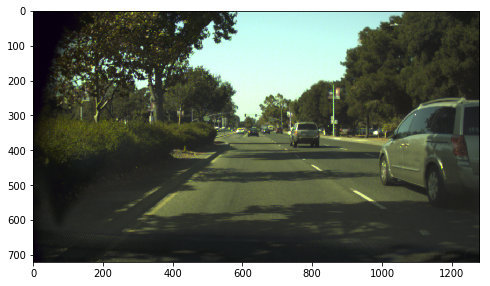

In [68]:
print(idx) # interesting ones: 1416 2261
print(tr[idx])
plt.figure(figsize=(8,6))
pth = os.path.join(train_folder,tr[idx]['path'])
img = plt.imread(pth)
plt.imshow(img)
plt.show()

In [69]:
# open the image in linux image viewer to be able to zoom easier
print(pth)
!eog {pth}

/media/yousof/Volume/SDC/DataSets/BoschTrafficLight/dataset_train_rgb.zip.001_FILES/./rgb/train/2015-10-05-14-40-46_bag/448216.png


In [49]:
tr_bxs = tr[idx]['boxes']
print(len(tr_bxs))
print(tr_bxs)

4
[{'label': 'off', 'occluded': False, 'x_max': 423.0509113815, 'x_min': 411.309086818, 'y_max': 288.9331130126, 'y_min': 260.9058359406}, {'label': 'Red', 'occluded': False, 'x_max': 694.060199093, 'x_min': 687.289898833, 'y_max': 276.7902623123, 'y_min': 259.99396886}, {'label': 'Red', 'occluded': False, 'x_max': 911.4915217589, 'x_min': 906.9799198912, 'y_max': 289.694767783, 'y_min': 273.5522193932}, {'label': 'GreenLeft', 'occluded': True, 'x_max': 424.4490445509, 'x_min': 413.5173675323, 'y_max': 325.7951406691, 'y_min': 300.2050785573}]


In [93]:
unique_labels = []
for item in tr:
    bboxes = item['boxes']
    if len(bboxes) > 0:
        for bbox in bboxes:
            label = bbox['label']
            if label not in unique_labels:
                unique_labels.append(label)

In [94]:
print(unique_labels)
print(len(unique_labels))

['Green', 'off', 'RedLeft', 'Red', 'Yellow', 'GreenStraight', 'GreenLeft', 'RedStraight', 'RedRight', 'GreenStraightRight', 'RedStraightLeft', 'GreenRight', 'GreenStraightLeft']
13


Now we have some ideas how to read, what kind of labels do we. Further anaylsis is possible like how many examples of each label exist and so on. The dataset's website says that the dataset includes 15 categories. Why is it 13??

# TFRecord

We need to turns the dataset to TFRecord formats to be able to use it in the tensorflow Object Detection API. I start with [this example](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_pets.md) and specially [this file](https://github.com/tensorflow/models/blob/master/research/object_detection/create_pet_tf_record.py) and also [this example](https://github.com/datitran/raccoon_dataset/blob/386a8f4f1064ea0fe90cfac8644e0dba48f0387b/test_generate_tfrecord.py).

In [156]:
import PIL.Image # pip install Pillow
import logging
import hashlib

from tqdm import tqdm

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

In [91]:
print(tr[0])
# randomise the training examples
random.seed(42)
random.shuffle(tr)
print(tr[0])

{'boxes': [], 'path': './rgb/train/2015-10-05-14-40-46_bag/560610.png'}
{'boxes': [{'label': 'Green', 'occluded': False, 'x_max': 1161.1124994744, 'x_min': 1132.3684383575, 'y_max': 257.4208702604, 'y_min': 191.1360314943}, {'label': 'off', 'occluded': False, 'x_max': 182.4656543346, 'x_min': 142.1854076827, 'y_max': 244.2121787714, 'y_min': 149.6616882748}, {'label': 'Green', 'occluded': False, 'x_max': 610.2982678607, 'x_min': 583.8013732683, 'y_max': 65.6359490294, 'y_min': 1.3718192029}], 'path': './rgb/train/2015-10-05-10-55-33_bag/53514.png'}


In [92]:
num_examples = len(tr)
print(num_examples)

5093


In [176]:
train_output_path = os.path.join(train_folder, 'traffic_train.record')
test_output_path = os.path.join(test_folder, 'traffic_test.record')
label_map_path = 'bosch_traffic_light_map.pbtxt'
label_map_dict = label_map_util.get_label_map_dict(label_map_path)
print(label_map_dict)

{'Green': 1, 'off': 2, 'RedLeft': 3, 'Red': 4, 'Yellow': 5, 'GreenStraight': 6, 'GreenLeft': 7, 'RedStraight': 8, 'RedRight': 9, 'GreenStraightRight': 10, 'RedStraightLeft': 11, 'GreenRight': 12, 'GreenStraightLeft': 13}


In [181]:
def dict_to_tf_example(data,
                       label_map_dict,
                       img_path,
                       ignore_difficult_instances=False):
    
    with tf.gfile.GFile(img_path, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = PIL.Image.open(encoded_jpg_io)
    if image.format != 'PNG':
        raise ValueError('Image format not PNG')
    key = hashlib.sha256(encoded_jpg).hexdigest()
    
    width, height = image.size
    width = int(width)
    height = int(height)
    
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    #truncated = []
    #poses = []
    difficult_obj = []
    
    for obj in data: # loop over bboxes
        difficult = obj['occluded']
        if difficult=='true' and ignore_difficult_instances==True:
            continue
        difficult_obj.append(difficult)
        
        # it is also normalising the bounding boxes
        xmin.append(float(obj['x_min']) / width) 
        ymin.append(float(obj['y_min']) / height)
        xmax.append(float(obj['x_max']) / width)
        ymax.append(float(obj['y_max']) / height)
        
        class_name = obj['label']
        classes_text.append(class_name.encode('utf8'))
        classes.append(label_map_dict[class_name]) # turns the name to the id
        
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image/height': dataset_util.int64_feature(height),
                'image/width': dataset_util.int64_feature(width),
                'image/encoded': dataset_util.bytes_feature(encoded_jpg),
                'image/filename': dataset_util.bytes_feature(img_path.encode('utf8')),
                'image/source_id': dataset_util.bytes_feature(img_path.encode('utf8')),
                'image/key/sha256': dataset_util.bytes_feature(key.encode('utf8')),
                'image/format': dataset_util.bytes_feature('png'.encode('utf8')),
                'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
                'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
                'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
                'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
                'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
                'image/object/class/label': dataset_util.int64_list_feature(classes),
                'image/object/difficult': dataset_util.int64_list_feature(difficult_obj)
                }
            )
        )
    return example
    
        
        
    
def create_tf_record(output_filename,examples,folder,label_map_dict,isTestDataset=False):
    writer = tf.python_io.TFRecordWriter(output_filename)
    for example in tqdm(examples): #loop over examples
        path = os.path.join(folder,example['path'])
        if isTestDataset==True: # because of bad naming in the file
            path = os.path.join(folder,'rgb/test',os.path.basename(path))
        if not os.path.exists(path):
            logging.warning('Could not find %s, ignoring example.', path)
            continue
        data = example['boxes']
        tf_example = dict_to_tf_example(data, label_map_dict, path)
        writer.write(tf_example.SerializeToString())
    
    writer.close()

In [174]:
create_tf_record(train_output_path,tr,train_folder,label_map_dict)

100%|██████████| 5093/5093 [05:07<00:00, 16.57it/s]


In [182]:
create_tf_record(test_output_path,te,test_folder,label_map_dict,isTestDataset=True)

100%|██████████| 8334/8334 [08:06<00:00, 17.14it/s]
